<a href="https://colab.research.google.com/github/anaacapilla/MIA3/blob/main/Jumanji_entregable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

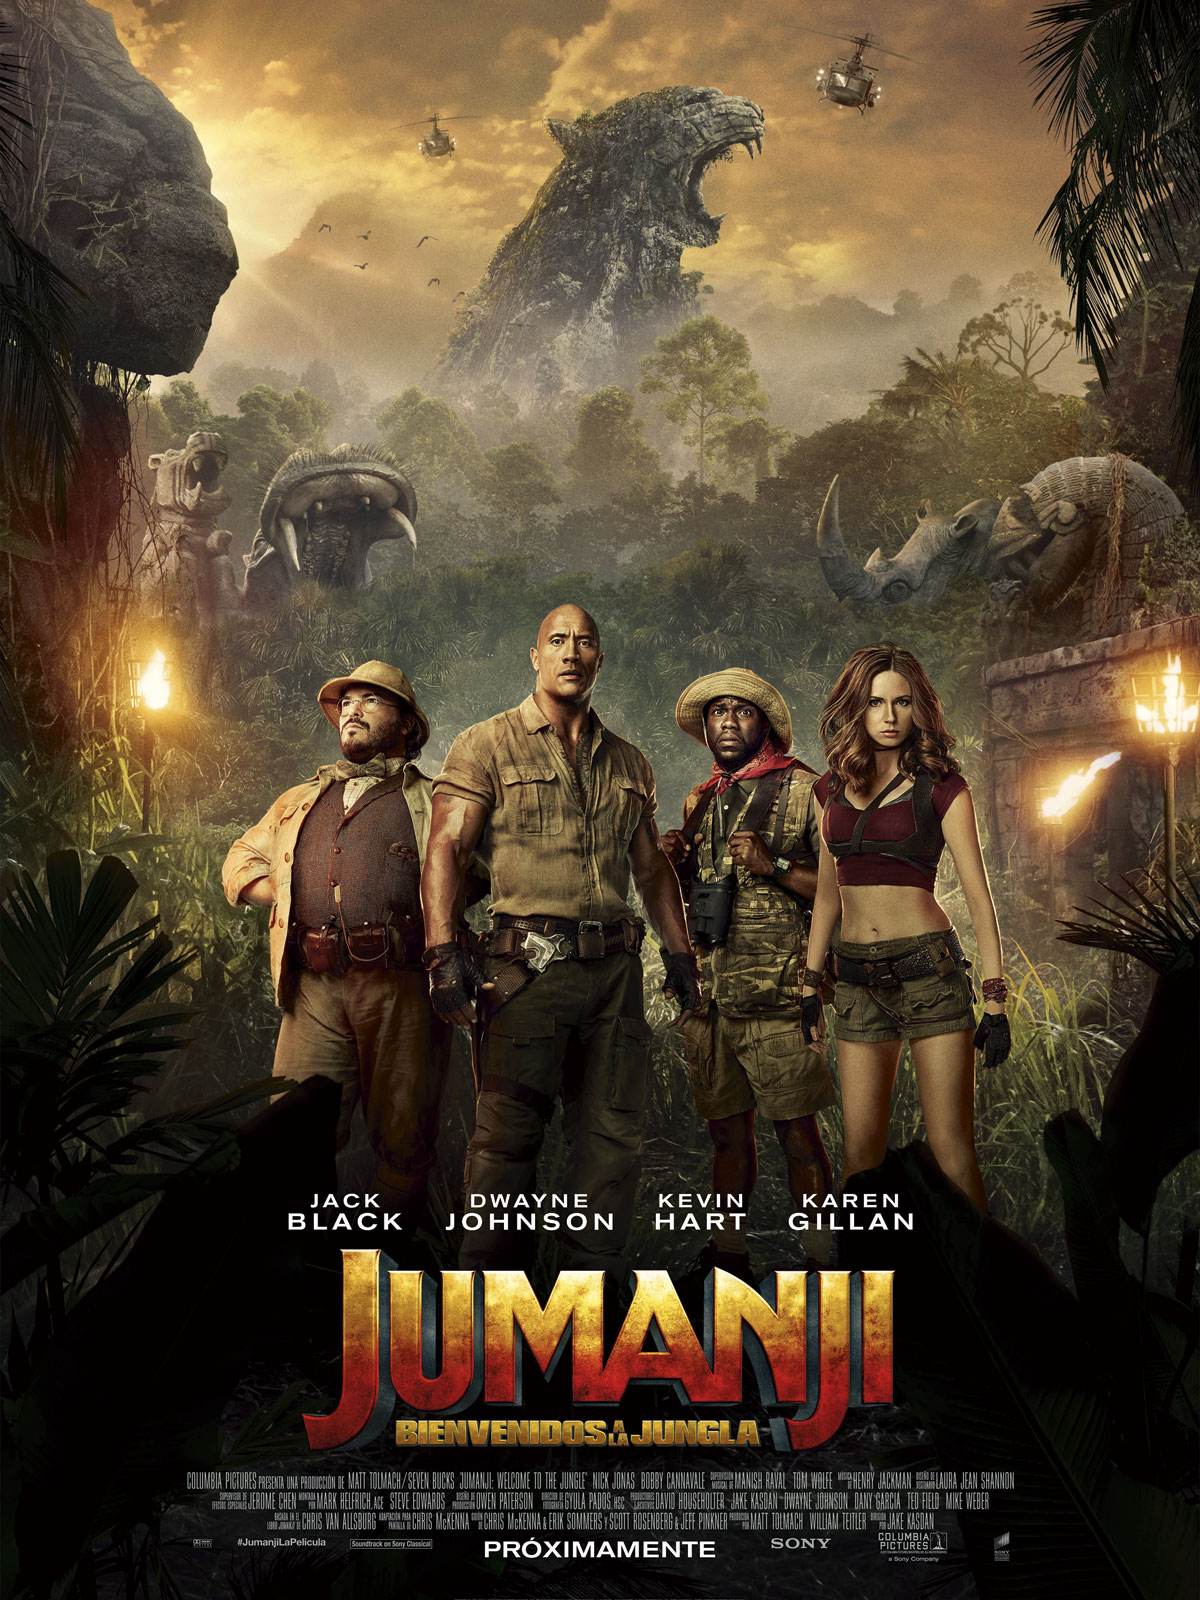

# Ejercicio Jumanji - Bienvenidos a la jungla

Wellcome to Jumanji dear adventurers. Unfortunately not everything are good news, some players have been playing to the game and, as a result of they dumb plays, a stampede of cats and dogs is now running in the real world.

As a fellow explorer I am sure that you understand the urgency of the situation. To solve it, we need to create a computer vision algorithm using CNNs to detect the cats and the dogs.

In order to do so we require the following steps:

- Create an image preprocessing pipeline to treat the images that we are providing. Perform data augmentation over the dataset, at least rotations.

- Test several architechtures (at least 3) and evaluate their performance over the dataset.

- Visualize the feature maps of some of the early and late layers of the models developed. ¿Is there any feature which could be explained through them?

- Finally select the model which performs the best over the whole dataset and explain why.

Fellow adventurer, thanks for your time, Jumanji will not forget your efforts.

# Import modules

In [93]:
import tensorflow.keras as keras
from shutil import copyfile
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import numpy as np
import os
from glob import glob
import random
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import classification_report
from keras.models import load_model
from matplotlib.ticker import MaxNLocator
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model, Sequence
from IPython.display import clear_output
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Import dataset

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /content/cats_and_dogs_filtered.zip
!unzip cats_and_dogs_filtered.zip

With the objective of understand better the different processes explained in class, we are going to perform the data preprocessing and data augmentation using two techniques. Our aim is to resize all the images to the same resolution without losing the ratio or any relevant part of the image. For that purpose, we are going to use `reshaping`, `padding` and `random rotation`. The two techniques are the following:

1. Custom functions: using custom functions built by us and preprocess "manually" the data.
2. Keras generators: define a custom keras generator that is in charge of performing the transformations at the same time the images are being loaded.
3. Use a predefined `ImageDataGenerator`.

# Import data

We are going to start by splitting a small section of the validation dataset in order to test the results of our models.

In [3]:
random.seed(42)

In [4]:
if not os.path.isdir('cats_and_dogs_filtered/validation_split'):
  os.mkdir('cats_and_dogs_filtered/validation_split')
  os.mkdir('cats_and_dogs_filtered/validation_split/cats')
  os.mkdir('cats_and_dogs_filtered/validation_split/dogs')

if not os.path.isdir('cats_and_dogs_filtered/test_split'):
  os.mkdir('cats_and_dogs_filtered/test_split')
  os.mkdir('cats_and_dogs_filtered/test_split/cats')
  os.mkdir('cats_and_dogs_filtered/test_split/dogs')

In [5]:
cat_files = glob("cats_and_dogs_filtered/validation/cats/*")
dog_files = glob("cats_and_dogs_filtered/validation/dogs/*")

random.shuffle(cat_files)
random.shuffle(dog_files)

for num, item in enumerate(cat_files):
  if num < 250:
    copyfile(item, item.replace("validation","validation_split"))
  else:
    copyfile(item, item.replace("validation","test_split"))
  
for num, item in enumerate(dog_files):
  if num < 250:
    copyfile(item, item.replace("validation","validation_split"))
  else:
    copyfile(item, item.replace("validation","test_split"))

# Data Augmentation

## 1.1. Data preprocessing - Custom functions

Our data is a folder called `cats_and_dogs_filtered` that contains two different folders, `train` and `validation`. As the data is already divided in train and test, we are going to perform data augmentation in our train dataset.

For this purpose we are going to use three functions developed in previous notebooks.
- **change_resolution** changes the resolution of the images.
- **padding** adds margins to the images in order to make them all of the same size.
- **random_rotation** random rotates the image in a range decided by the user.

Once this is done, the preprocessed data will be stored in a new folder called `preprocessed_dataset`.

In [ ]:
def change_resolution(img,n):
  width, height = img.size
  aspect_relatio = height/width
  if height > width:
    new_height = n
    new_width = round(n/aspect_relatio)
  else:
    new_width = n
    new_height = round(n*aspect_relatio)
  reshaped_img = img.resize((new_width,new_height))
  return reshaped_img

In [ ]:
def padding(img,n):
  array = np.array(img)
  width = array.shape[0]
  height = array.shape[1]
  left_width = n - width
  left_height = n - height

  ancho_izq = 0
  ancho_dcha = 0
  alto_arriba = 0
  alto_abajo = 0

  if left_width == 0:
    aux = left_height/2
    alto_arriba = np.ceil(aux).astype(int)
    alto_abajo = np.floor(aux).astype(int)

  elif left_height == 0:
    aux = left_width/2
    ancho_izq = np.ceil(aux).astype(int)
    ancho_dcha = np.ceil(aux).astype(int)

  padded_img = np.pad(array,((ancho_izq,ancho_dcha),(alto_arriba,alto_abajo),(0,0)))
  img_padded = Image.fromarray(padded_img)

  return img_padded

In [ ]:
def random_rotation(img, max):
  angle = random.randint(-max,max)
  rotated_img = img.rotate(angle)
  return rotated_img

As we have to preprocess either train and validation folders, we are going to code a loop that will do this job.

In [ ]:
original_paths = ["train/cats", "train/dogs","validation/cats","validation/dogs"]

In [ ]:
for item in tqdm(original_paths):
  preprocess_path = f"preprocessed_dataset/{item}" 
  os.makedirs(preprocess_path, exist_ok=True)
  files = os.listdir(f"cats_and_dogs_filtered/{item}")
  for file_ in files:
    path = os.path.join(f"cats_and_dogs_filtered/{item}", file_)
    img = Image.open(path)
    resized_img = change_resolution(img, 128)
    padded_img = padding(resized_img, 128)
    rotated_img = random_rotation(padded_img,30)
    save_path = os.path.join(preprocess_path, file_)
    rotated_img.save(save_path)

100%|██████████| 4/4 [00:15<00:00,  3.80s/it]


## 1.2. Data preprocessing - Custom Keras Generator

We are going to perform the data augmentation in the train dataset in order to make our algorithm stable even with translations or rotations.

In [ ]:
angle = (2*3.1416*30)/360 # 30º of rotation

In [ ]:
class ImageResizer(Sequence):
  def __init__(self, data_folder, img_shape, rotation, batch_size=32, to_fit=True):
    self.data_folder = data_folder
    self.files = [os.path.join(path, name) for path, subdirs, files in os.walk(data_folder) for name in files]
    shuffle(self.files)
    self.rotation = rotation
    self.batch_size = batch_size
    self.shape = img_shape
    self.to_fit = True

  def __len__(self):
    batches = int(np.floor(len(self.files) / self.batch_size))
    return batches

  def __getitem__(self, index):
    batch_files = self.files[
                             index * self.batch_size : (index + 1) * self.batch_size
                            ]
    if self.to_fit:
      X = self._generate_X(batch_files)
      y = self._generate_Y(batch_files)
      return X, y
    else:
      X = self._generate_X(batch_files)
      return X

  def _generate_X(self, batch_files):
    shape = [self.batch_size]
    shape.extend(self.shape)
    shape.extend([3])
    X = np.zeros(shape=shape)
    for i, file_ in enumerate(batch_files):
      img = Image.open(file_)
      resize_image = self._change_resolution(img)
      padding_image = self._pad_img(resize_image)
      img_padded = Image.fromarray(padding_image)
      rotated_img = self._random_rotation(img_padded)
      rotated_array = np.array(rotated_img)
      X[i, :, :, :] = rotated_array
    return X

  def _pad_img(self, img):
    width, height = img.size
    desired_resolution = self.shape[0]
    array = np.array(img)
    if width > height:
      total_pad = desired_resolution - height
      pad = total_pad/2
      if isinstance(pad, float):
        pad_0 = int(np.ceil(pad))
        pad_1 = int(np.floor(pad))
        padded_image = np.pad(array, ((pad_0, pad_1),(0,0),(0,0)))
      else:
        padded_image = np.pad(array, ((pad, pad),(0,0),(0,0)))
    else:
      total_pad = desired_resolution - width
      pad = total_pad/2
      if isinstance(pad, float):
        pad_0 = int(np.ceil(pad))
        pad_1 = int(np.floor(pad))
        padded_image = np.pad(array, ((0,0),(pad_0, pad_1),(0,0)))
      else:
        padded_image = np.pad(array, ((0,0),(pad, pad),(0,0)))
    return padded_image

  def _change_resolution(self, img):
    desired_resolution = self.shape[0]
    width, height = img.size
    if width > height:
      aspect_relatio = width/height
      new_width = desired_resolution
      new_height = round(desired_resolution/aspect_relatio)
      resized_img = img.resize((new_width,new_height))
    else:
      aspect_relatio = height/width
      new_height = desired_resolution
      new_width = round(desired_resolution/aspect_relatio)
      resized_img = img.resize((new_width,new_height))
    return resized_img

  def _random_rotation(self,img):
    angle = random.randint(-self.rotation,self.rotation)
    rotated_img = img.rotate(angle)
    return rotated_img

  def _generate_Y(self, batch_files):
    y = list()
    for file_ in batch_files:
      label = file_.split("/")
      y.append(label[2])
    df_labels = pd.DataFrame(y)
    y_dummies = pd.get_dummies(df_labels).values
    return y_dummies

In [ ]:
train_generator = ImageResizer("cats_and_dogs_filtered/train", (128,128), rotation=30, batch_size=128)
val_generator = ImageResizer("cats_and_dogs_filtered/validation", (128,128), rotation = 30, batch_size=128, to_fit=False)

In [ ]:
number_train_samples = len(train_generator.files)
number_val_samples   = len(val_generator.files)

number_train_samples, number_val_samples

## 1.3. Data preprocessing - ImageDataGenerator

The last option is to use predefined Keras DataGenerators. This is the option that we are going to use in this project.

We start performing a normalization of the image. Our `ImageDataGenerator` also performs rotations, shifts, zooms and flips.

In [40]:
preprocess_input = lambda x:x/255.

In [41]:
train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function = preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='mirror',
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen  = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

test_datagen  = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

Then we are going to load the data from our directory. We set a batch_size of 128 and set the shuffle to True in train and to False in validation.

In [42]:
train_generator = train_datagen.flow_from_directory(
    "cats_and_dogs_filtered/train",
    target_size=(128,128),
    batch_size=128,
    shuffle=True) # binary, categorical, sparse

val_generator = val_datagen.flow_from_directory(
    "cats_and_dogs_filtered/validation_split",
    target_size=(128,128),
    batch_size=128,
    shuffle=False) # binary, categorical, sparse

test_generator = test_datagen.flow_from_directory(
    "cats_and_dogs_filtered/test_split",
    target_size=(128,128),
    batch_size=128,
    shuffle=False)

Found 2000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


Finally we store the length of the datasets.

In [43]:
number_train_samples = train_generator.n
number_val_samples   = val_generator.n

number_train_samples, number_val_samples

(2000, 500)

In [44]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

# Image visualization

Cat


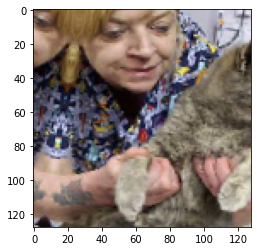

Cat


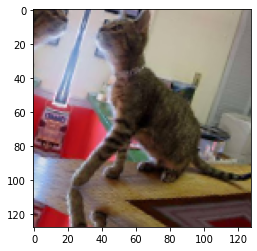

Dog


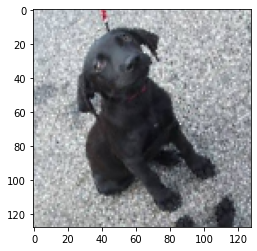

Dog


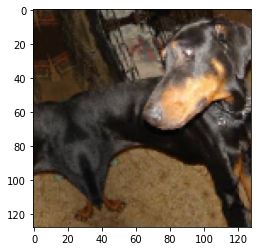

Cat


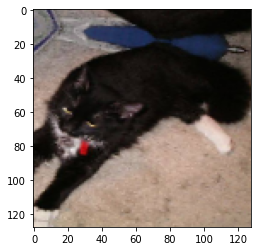

In [48]:
img, label = train_generator.next()

for i in range(5):
    if label[i].argmax() == 0:
      print("Cat")
    else:
      print("Dog")
    plt.imshow(img[i])
    plt.show()

We are going to define the function `grafica_entrenamiento`, that will show the progress of the training loss and the accuracy on each epoch.

In [51]:
def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

# Model 1

In [83]:
input_layer = Input(shape=(128,128,3))

conv_layer1 = Conv2D(32, (3,3), activation = "relu", padding = "same")(input_layer)
conv_layer2 = Conv2D(32, (3,3), activation = "relu", padding = "same")(conv_layer1)
pool_layer1 = MaxPool2D(pool_size = (2,2), strides = (2,2))(conv_layer2)

conv_layer3 = Conv2D(64, (3,3), activation = "relu", padding = "same")(pool_layer1)
pool_layer2 = MaxPool2D(pool_size = (2,2), strides = (2,2))(conv_layer3)

conv_layer4 = Conv2D(64, (3,3), activation = "relu", padding = "same")(pool_layer2)
pool_layer3 = MaxPool2D(pool_size = (2,2), strides = (2,2))(conv_layer4)

dropout = Dropout(0.2)(pool_layer3)

flatten = Flatten(data_format="channels_last")(dropout)

dense1 = Dense(64, activation = "relu")(flatten)
dense2 = Dense(128, activation = "relu")(dense1)
dense3 = Dense(2, activation = "softmax")(dense2)

In [84]:
model1 = keras.Model(inputs = input_layer, outputs = dense3)
model1.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics="accuracy")

In [85]:
acum_tr_acc1 = []
acum_val_acc1 = []
best_val_acc1 = -1000
acum_tr_loss1  = []
acum_val_loss1 = []

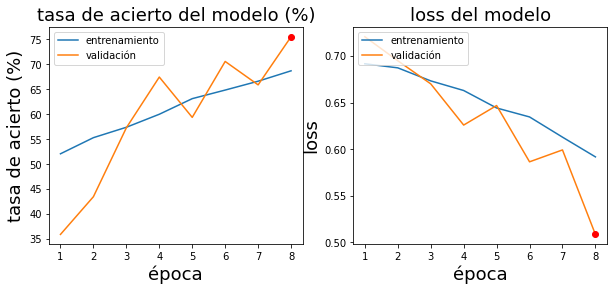

Epoch number 8
15/15 [==============================] - ETA: 0s - loss: 0.5695 - accuracy: 0.7063

KeyboardInterrupt: ignored

In [86]:
batch_size = 128
epochs = 25

modelpath1 = "model1.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                             save_best_only=True,
                             mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]
for e in range(epochs):
    print(f"Epoch number {e}")
    history = model1.fit(train_generator, 
                        steps_per_epoch=number_train_samples // batch_size,
                        epochs=1,
                        callbacks=callbacks_list,
                        verbose=1,
                        shuffle = False,
                        validation_data=val_generator,
                        validation_steps=number_val_samples // batch_size
                       )
    
    if history.history['val_accuracy'][-1] > best_val_acc1:
        print("Validation accuracy improved from",
            best_val_acc1, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc1 = history.history['val_accuracy'][-1]
    
    acum_tr_acc1.append(history.history['accuracy'][0])
    acum_val_acc1.append(history.history['val_accuracy'][0])
    acum_tr_loss1.append(history.history['loss'][0])
    acum_val_loss1.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc1) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc1)
        grafica_entrenamiento(acum_tr_acc1, acum_val_acc1, acum_tr_loss1, acum_val_loss1, best_i)

# Model 2

In [ ]:
input_layer = Input(shape=(64,64,3))

conv_layer1 = Conv2D(32, (3,3), activation = "relu", padding = "same")(input_layer)
conv_layer2 = Conv2D(32, (3,3), activation = "relu", padding = "same")(conv_layer1)

pool_layer1 = MaxPool2D(pool_size = (2,2), strides = (2,2))(conv_layer2)

conv_layer3 = Conv2D(64, (3,3), activation = "relu", padding = "same")(pool_layer1)
conv_layer4 = Conv2D(64, (3,3), activation = "relu", padding = "same")(conv_layer3)

pool_layer2 = MaxPool2D(pool_size = (2,2), strides = (2,2))(conv_layer4)

conv_layer5 = Conv2D(128, (5,5), activation = "relu", padding = "same")(pool_layer1)
conv_layer6 = Conv2D(128, (5,5), activation = "relu", padding = "same")(conv_layer3)

pool_layer2 = MaxPool2D(pool_size = (2,2), strides = (2,2))(conv_layer4)

flatten = Flatten(data_format="channels_last")(pool_layer2)

dense1 = Dense(128, activation = "relu")(flatten)
dense2 = Dense(64, activation = "relu")(dense1)
dense3 = Dense(64, activation = "relu")(dense2)
dense4 = Dense(2, activation = "relu")(dense3)

In [ ]:
model2 = keras.Model(inputs = input_layer, outputs = dense4)
model2.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics="accuracy")

In [ ]:
acum_tr_acc2 = []
acum_val_acc2 = []
best_val_acc2 = -1000
acum_tr_loss2  = []
acum_val_loss2 = []

In [ ]:
batch_size = 128
epochs = 25

modelpath2 = "model2.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                             save_best_only=True,
                             mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]
for e in range(epochs):
    print(f"Epoch number {e}")
    history = model2.fit(train_generator, 
                        steps_per_epoch=number_train_samples // batch_size,
                        epochs=1,
                        callbacks=callbacks_list,
                        verbose=1,
                        shuffle = False,
                        validation_data=val_generator,
                        validation_steps=number_val_samples // batch_size
                       )
    
    if history.history['val_accuracy'][-1] > best_val_acc2:
        print("Validation accuracy improved from",
            best_val_acc2, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc2 = history.history['val_accuracy'][-1]
    
    acum_tr_acc2.append(history.history['accuracy'][0])
    acum_val_acc2.append(history.history['val_accuracy'][0])
    acum_tr_loss2.append(history.history['loss'][0])
    acum_val_loss2.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc2) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc2)
        grafica_entrenamiento(acum_tr_acc2, acum_val_acc2, acum_tr_loss2, acum_val_loss2, best_i)

# Model 3

In [ ]:
input_layer = Input(shape=(64,64,3))

conv_layer1 = Conv2D(32, (3,3), activation = "relu", padding = "same")(input_layer)
pool_layer1 = MaxPool2D(pool_size = (2,2), strides = (2,2))(conv_layer1)
conv_layer2 = Conv2D(32, (3,3), activation = "relu", padding = "same")(pool_layer1)
pool_layer2 = MaxPool2D(pool_size = (2,2), strides = (2,2))(conv_layer2)
conv_layer3 = Conv2D(128, (5,5), activation = "relu", padding = "same")(pool_layer2)
pool_layer3 = MaxPool2D(pool_size = (2,2), strides = (2,2))(conv_layer3)

flatten = Flatten(data_format="channels_last")(pool_layer3)

dense1 = Dense(32, activation = "relu")(flatten)
dense2 = Dense(2, activation = "relu")(dense1)

In [ ]:
model3 = keras.Model(inputs = input_layer, outputs = dense2)
model3.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics="accuracy")

In [ ]:
acum_tr_acc3 = []
acum_val_acc3 = []
best_val_acc3 = -1000
acum_tr_loss3  = []
acum_val_loss3 = []

In [ ]:
batch_size = 128
epochs = 25

modelpath3 = "model3.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                             save_best_only=True,
                             mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]
for e in range(epochs):
    print(f"Epoch number {e}")
    history = model3.fit(train_generator, 
                        steps_per_epoch=number_train_samples // batch_size,
                        epochs=1,
                        callbacks=callbacks_list,
                        verbose=1,
                        shuffle = False,
                        validation_data=val_generator,
                        validation_steps=number_val_samples // batch_size
                       )
    
    if history.history['val_accuracy'][-1] > best_val_acc3:
        print("Validation accuracy improved from",
            best_val_acc3, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc3 = history.history['val_accuracy'][-1]
    
    acum_tr_acc3.append(history.history['accuracy'][0])
    acum_val_acc3.append(history.history['val_accuracy'][0])
    acum_tr_loss3.append(history.history['loss'][0])
    acum_val_loss3.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc3) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc3)
        grafica_entrenamiento(acum_tr_acc3, acum_val_acc3, acum_tr_loss3, acum_val_loss3, best_i)

# Model 4

In [ ]:
input_layer = Input(shape=(64,64,3))

conv_layer1 = Conv2D(128, (3,3), activation="relu", padding="same", input_shape=(64,64,3))(input_layer)
conv_layer2 = Conv2D(128, (3,3), activation="relu", padding="same")(conv_layer1)
conv_layer3 = Conv2D(64, (3,3), activation="relu", padding="same")(conv_layer2)

pool_layer1 = MaxPool2D(pool_size = (2,2), strides = (2,2))(conv_layer3)

conv_layer4 = Conv2D(64, (3,3), activation="relu", padding="same")(pool_layer1)
conv_layer5 = Conv2D(64, (3,3), activation="relu", padding="same")(conv_layer4)
conv_layer6 = Conv2D(32, (3,3), activation="relu", padding="same")(conv_layer5)

pool_layer2 = MaxPool2D(pool_size = (2,2), strides = (2,2))(conv_layer6)

conv_layer7 = Conv2D(10, (3,3), activation="relu", padding="same")(pool_layer2)
conv_layer8 = Conv2D(10, (3,3), activation="relu", padding="same")(conv_layer7)
conv_layer9 = Conv2D(10, (3,3), activation="relu", padding="same")(conv_layer8)

pooling = MaxPool2D(pool_size=(2,2))(conv_layer9)

flatten = Flatten(data_format="channels_last")(pooling)

dense1 = Dense(256, activation="tanh")(flatten)
dense2 = Dense(62, activation = "relu")(dense1)
classifier = Dense(2, activation="softmax")(dense2)

In [ ]:
model4 = keras.Model(inputs=input_layer, outputs=classifier)
model4.compile(optimizer="adam", loss="categorical_crossentropy",metrics = "accuracy")

In [ ]:
acum_tr_acc4 = []
acum_val_acc4 = []
best_val_acc4 = -1000
acum_tr_loss4  = []
acum_val_loss4 = []

In [ ]:
batch_size = 128
epochs = 25

modelpath4 = "model4.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                             save_best_only=True,
                             mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]
for e in range(epochs):
    print(f"Epoch number {e}")
    history = model4.fit(train_generator, 
                        steps_per_epoch=number_train_samples // batch_size,
                        epochs=1,
                        callbacks=callbacks_list,
                        verbose=1,
                        shuffle = False,
                        validation_data=val_generator,
                        validation_steps=number_val_samples // batch_size
                       )
    
    if history.history['val_accuracy'][-1] > best_val_acc4:
        print("Validation accuracy improved from",
            best_val_acc4, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc4 = history.history['val_accuracy'][-1]
    
    acum_tr_acc4.append(history.history['accuracy'][0])
    acum_val_acc4.append(history.history['val_accuracy'][0])
    acum_tr_loss4.append(history.history['loss'][0])
    acum_val_loss4.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc4) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc4)
        grafica_entrenamiento(acum_tr_acc4, acum_val_acc4, acum_tr_loss4, acum_val_loss4, best_i)

# Comparison of the models

In [96]:
model1 = load_model(modelpath1)
# model2 = load_model(modelpath2)
# model3 = load_model(modelpath3)
# model4 = load_model(modelpath4)

In [97]:
models = [model1] # model2, model3, model4]

In [98]:
for num, model in enumerate(models):
  print(f"** MODEL {num+1} - RESULTS **")

  scores_tr = model.evaluate(train_generator)
  print('Train loss    :', scores_tr[0])
  print('Train accuracy:', scores_tr[1])
  print()

  scores_val = model.evaluate(val_generator)
  print('Val loss    :', scores_val[0])
  print('Val accuracy:', scores_val[1])
  print()

  scores_te = model.evaluate(test_generator)
  print('Test loss     :', scores_te[0])
  print('Test accuracy :', scores_te[1])

** MODEL 1 - RESULTS **
16/16 [==============================] - 12s 712ms/step - loss: 0.5838 - accuracy: 0.6910
Train loss    : 0.5837859511375427
Train accuracy: 0.6909999847412109

4/4 [==============================] - 2s 595ms/step - loss: 0.5504 - accuracy: 0.7040
Val loss    : 0.5504372715950012
Val accuracy: 0.7039999961853027

4/4 [==============================] - 1s 295ms/step - loss: 0.5991 - accuracy: 0.6700
Test loss     : 0.5990952253341675
Test accuracy : 0.6700000166893005


In [101]:
img, y_true = test_generator.next() # 128 samples

y_pred = model.predict(test_generator) # 500 samples


KeyboardInterrupt: ignored

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


In [100]:
print(classification_report(y_true, y_pred, labels=["cat", "dog"]))

ValueError: ignored